## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction


For this project, I will be working to understand the results of an A/B test run by an e-commerce website. My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability



In [69]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)



a. Read in the dataset and take a look at the top few rows here:

In [70]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b.find the number of rows in the dataset.

In [71]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [72]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

d. The proportion of users converted.

In [73]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `Treatment` don't line up.

In [74]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

e. The number of times the `old_page` and `control` don't line up.

In [75]:
df[((df['group'] == 'control') == (df['landing_page'] == 'old_page')) == False].shape[0]

3893

f. checking for missing values

In [76]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.


In [77]:
# creating a new dataframe while droping all rows where treatment is not aligned with new_page or control is not aligned with old_page
df2 = df.drop(df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].index)

In [78]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [79]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'control') == (df2['landing_page'] == 'old_page')) == False].shape[0]

0

a. How many unique **user_id**s are in **df2**?

In [80]:
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

b. There is one **user_id** repeated in **df2**

In [81]:
# Assigning the column “is_duplicate” to the dataframe df2 with the values True (if duplicate) 
# and False (if not a duplicate)
df2['is_duplicate'] = df2.duplicated('user_id')
# now I can display the row which has the value True and therefore is the duplicate in the df.
df2.query('is_duplicate == True')

,user_id,timestamp,group,landing_page,converted,is_duplicate
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0,True


c. getting the row information for the repeat **user_id**? 

In [82]:
# Since I now know the user_id of the duplicate, I can get the two rows for this user
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted,is_duplicate
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0,False
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0,True


d. Removing **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [83]:
# dropping row 2893 
df2.drop(df.index[2893], inplace=True)


In [84]:
# checking if the operation was succesfull
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted,is_duplicate
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0,False


In [85]:
# now I will also drop the is_duplicated column which I just needed to idenyfying the duplic
df2.drop(['is_duplicate'], axis=1, inplace=True)

a. What is the probability of an individual converting regardless of the page they receive?

In [86]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [87]:
df2[df2['group'] == 'control'].converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [88]:
df2[df2['group'] == 'treatment'].converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [89]:
df.groupby('landing_page').count()

,user_id,timestamp,group,converted
landing_page,,,,
new_page,147239,147239,147239,147239
old_page,147239,147239,147239,147239


### The results shows that the difference in the probability to convert in the treatment group (0.1188) and the controll group (0.1203) are almost identical. If you would round to two decimals, the probabilities would be the same: 0.12
### The results therefore show that the implemation of the new page will not lead to a change in the conversion rate. 

<a id='ab_test'></a>
### Part II - A/B Test 

`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

### **$H{0}$** = **$p_{new}$** - **$p_{old}$** ≤ 0 

### **$H{1}$**  = **$p_{new}$** - **$p_{old}$** < 0


`2.`  I assume that under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, I assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

I use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>


a. What is the **convert rate** for $p_{new}$ under the null? 

In [90]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [91]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [92]:
n_new = df2[df2['landing_page'] == 'new_page'].shape[0]
n_new

145310

d. What is $n_{old}$?

In [93]:
n_old = df2[df2['landing_page'] == 'old_page'].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [94]:
new_page_converted = np.random.binomial(n_new, p_new)/n_new
new_page_converted

0.118938820452825

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [95]:
old_page_converted = np.random.binomial(n_old, p_old)/n_old
old_page_converted

0.12146702093974146

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [96]:
np.round(new_page_converted-old_page_converted)

-0.0

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [97]:
#for 10,000 iterations, bootstrap sample your sample data 
#compute the difference in the average probability to convert between
#new page and old page
# if I ran 10,000 iterations, the kernel would always "crash". So i needed to the run the iterations with just 1,000

p_diffs = []
size = df2.shape[0]
for _ in range(1000):
    bootsample = df2.sample(size, replace=True)
    p_new = bootsample.converted.mean()
    p_old = bootsample.converted.mean()
    n_new = bootsample[bootsample['landing_page'] == 'new_page'].shape[0]
    n_old = bootsample[bootsample['landing_page'] == 'old_page'].shape[0]
    new_page_converted = np.random.binomial(n_new, p_new)/n_new
    old_page_converted = np.random.binomial(n_old, p_old)/n_old
    p_diffs.append(new_page_converted - old_page_converted)   

i. Plot a histogram of the **p_diffs**

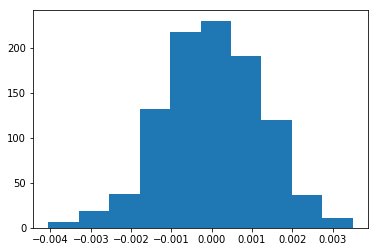

In [98]:
# Convert to numpy array
p_diffs = np.array(p_diffs)

# Plot sampling distribution
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

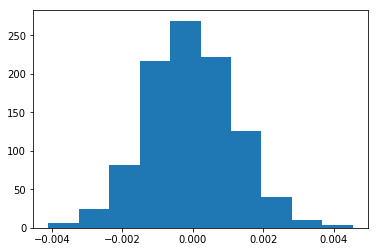

In [99]:
# Simulate distribution under the null hypothesis
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

# Plot the null distribution
plt.hist(null_vals);

In [100]:
# calculating the observed difference in df2 between treatment and controll group
obs_diff = (df2[df2['group'] == 'control'].converted.mean()-df2[df2['group'] == 'treatment'].converted.mean())

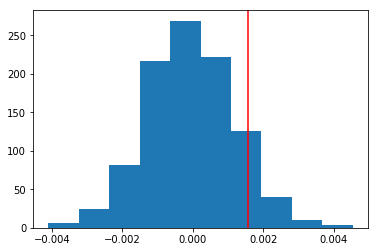

In [101]:
# Plot observed statistic with the null distibution
plt.hist(null_vals);
plt.axvline(obs_diff, c='red');
# the red line shows the observed difference from the dataframe (df2)

In [107]:
# Compute p-value
# the proportion of values from our null distribution that are greater than the observed mean
(null_vals > obs_diff).mean()

0.106

### In part j I calculated the so called p-value, which determines under a given α (here 0.05) the probality that we reject the null hypothesis even though its true (Type 1 error). Based on the p-value we can make a decision if we reject the null hypothesis (and act if the alternate hypothesis is true for the observed population) or if we can not reject the null hypothesis. 
### A p-value below the α would give us the confidence to reject the null hypthesis (and act if the alternate hypothesis is true for the observed population)- With a p-value above the α we can not reject the null hypothesis. 
### Since the above calculated p-value (0.106) is above our previously established α level we can not reject the null hypothesis.
### This means that the difference between the conversation rate of the new and old page is 0 or lower than 0. 

#### (source: http://knowledgetack.com/python/statsmodels/proportions_ztest/)

In [108]:
import statsmodels.api as sm

# calculating calculate the number of conversions for each page,
# as well as the number of individuals who received each page
convert_old = df2[df2['landing_page'] == 'old_page'].converted.mean()
convert_new = df2[df2['landing_page'] == 'new_page'].converted.mean()
n_old = df2[df2['landing_page'] == 'old_page'].shape[0]
n_new = df2[df2['landing_page'] == 'new_page'].shape[0]

m. I use `stats.proportions_ztest` to compute your test statistic and p-value.

In [109]:
# the proportions_ztest returns a z-score and a p-value. 
# in this case we do a one-tail test
#(source: http://knowledgetack.com/python/statsmodels/proportions_ztest/)
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='larger')
z_score, p_value

(0.0032875796753531767, 0.49868844782989563)

### As mentioned before, the set alpa is 0.05 (significance level 95%), a z-score past 1.96 will be significant (one-tail test for the difference).
(source: http://knowledgetack.com/python/statsmodels/proportions_ztest/)

In [110]:
# norm.cdf shows significant our z-score is
# norm.ppf calcutes the critical value at 95% confidence intervall
#(source: http://knowledgetack.com/python/statsmodels/proportions_ztest/)
from scipy.stats import norm
norm.cdf(z_score), norm.ppf(1-(0.05))

(0.50131155217010437, 1.6448536269514722)

### The z-value is below the critical value of 1.644, which means that we can not reject the null hypothesis  that the difference in the conversation rate between the old and the new page is 0 or smaller than zero. These are the same findings as we had in parts j. and k. 
### However, the p-value shows that our z-score isnt significant either

<a id='regression'></a>
### Part III - A regression approach


### We use the Logistic Regression since the outcome "converted" is either a success ("1") or a failure ("0"). In this cases we would like to know the probality of an outcome instead of the respone.
### Logistic regression is used to predict only to outcomes, in this case converted or not converted

In [111]:
#adding an intercept column and an ab_page column, 
#which is 1 when an individual receives the treatment and 0 if control
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['landing_page'])['new_page']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [112]:
# Instantiate the model, and fit the model 
log_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results_log_mod = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [113]:
# summary of the logistic regression
results_log_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 08 Jan 2019   Pseudo R-squ.:               8.077e-06
Time:                        16:52:33   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

### Here we would like to know if the page (old or new) influences the probality of the prediction of the conversion (probality between 0 and 1), instead of predicting the response of the dependent variable "converted". 

#### Generally, the hypothesis for logistic regression are defined as following:
(source:http://ismayc.github.io/teaching/sample_problems/multiple_logistic.html)

#### Null hypothesis: The coefficients on the parameters (including interaction terms) of the logistic regression modeling log(odds) of Vote as a function of log contribution and party are zero.

#### Alternative hypothesis: At least one of the coefficients on the parameters (including interaction terms) of the logistic regression modeling log(odds) of Vote as a function of log contribution and party are nonzero.

### The null hypothesis in this case would be that the page has no influence on the probability that a user converts. Accordingly,  the alternative hypothesis would be that the page has  influence on the probability that a user converts
#### Here, the influence of the page is not significant (p-value: 0.190). So we can not reject the null hypthesis.

### The advantage of adding other factors to the regression is that we get a better picture how certain factors effekt the response (here the variable converted). There might be other factors that influence whether or not an indivudal converts which would help us to make an informed decision

### The disadvantage could be that the factors could be related to each other (multicollinearity) which could lead to results that are not reliable and that the results between the x factors and the response (y) dont hold our expectations.



Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns. Provide the statistical output as well as a written response to answer this question.

In [114]:
# Read in the dataset for the countries and take a look at the top few rows here:
df_country = pd.read_csv('countries.csv')
df_country.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [116]:
# now i will check how many different countries are included in the dataframe
df_country.country.nunique()

3

In [117]:
# Now I merge rows with the df2 to have all data in one dataframe (df3)
# and look at the top 5 rows
df3 = df2.merge(df_country, on='user_id')
df3.head()          

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [118]:
# now I will create dummies variables for the 3 countries (US, UK, CA)
# and store them in 3 columns (and drop the first level to get k-1 dummies). 
# Then I look at the top 5 rows
country_dummies = pd.get_dummies(df3['country'], drop_first = True)
df3 = df3.join(country_dummies)
df3.head(5)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,1


In [119]:
#Instantiate the model, and fit the model and summary of the logistic regression
log_mod_2 = sm.Logit(df3['converted'], df3[['intercept','UK','US']])
results_log_mod_2 = log_mod_2.fit()
results_log_mod_2.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Tue, 08 Jan 2019   Pseudo R-squ.:               1.521e-05
Time:                        16:53:10   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

### Since the p-values are higher than our alpa (0.05), the influence of country is not significant (p-value: UK- 0.074; US 0.129). So we can not reject the null hypthesis that the influence of the country is zero.

h. Though I have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion. 

In [120]:
#Instantiate the model, and fit the model and summary of the logistic regression
log_mod_3 = sm.Logit(df3['converted'], df3[['intercept','ab_page','UK','US']])
results_log_mod_3 = log_mod_3.fit()
results_log_mod_3.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 08 Jan 2019   Pseudo R-squ.:               2.323e-05
Time:                        16:53:24   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

###  Since the p-values ( ab_page: 0.191; UK: 0.074; US: 0.130) are higher than our alpa (0.05), the influence of country and the page is not significant. So we can not reject the null hypthesis that the influence of the country or the page is zero.


## CONCLUSION

### Base on the findinds that the page has no influence on the conversation or on the probability that a user converts, I would recommend the e-commerce company to keep the old page. An investment in the new page would not make sense. 

###  I would also recommend to run the experience longer since the time period of 22 days is too short to make a more confident decision.

In [121]:
(df3.timestamp.min(), df3.timestamp.max())

('2017-01-02 13:42:05.378582', '2017-01-24 13:41:54.460509')

### The user might havent got used to the new design and rejects the new design because of that respectively not finished the check out due not being used to the new design.